In [1]:
# Basic Libraries
import sys
import time
import gc
import random

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")
import cca_core
from netrep.metrics import LinearMetric
import networks as nets  # Contains RNNs
import net_helpers
import tasks
import helper
import mpn

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygo' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],

     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],

     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
hyp_dict['addon_name'] = ""

mpn_depth = 1

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': False, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 64,
        'batch_size': 64,
        # 'gradient_clip': 10,
        'valid_n_batch': 200,
        'n_datasets': 100, # Number of distinct batches
        'n_epochs_per_set': 50, # longer/shorter training
        'task_mask': None, # None, task
        # 'weight_reg': 'L2',
        # 'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    n_hidden = 100

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': 100,
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': True,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 400, # ms, sets lambda
            'lam_train': True,
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

Set seed 104
Fixation_off: False; Task_info: True
Rules: ['delaygo']
  Input size 6, Output size 3
Using CUDA...


In [4]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [5]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim"

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix)
    _, test_trials, test_rule_idxs = test_trials_extra

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    labels = []
    for rule_idx, rule in enumerate(task_params['rules']):
        print(rule)
        if rule in accept_rules:
            if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                labels.append(test_trials[rule_idx].meta['matches'])
            else:
                labels.append(test_trials[rule_idx].meta['resp1' if color_by == "resp" else 'stim1'])

        else:
            raise NotImplementedError()
    labels = np.concatenate(labels, axis=0).reshape(-1,1)

test_input, test_output, test_mask = test_data

permutation = np.random.permutation(test_input.shape[0])
test_input = test_input[permutation]
test_output = test_output[permutation]
test_mask = test_mask[permutation]
labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

n_batch_all = test_input_np.shape[0] # Total number of batches, might be different than test_n_batch
max_seq_len = test_input_np.shape[1]

Align ['delaygo'] With Same Time
rng reset with seed 3096
delaygo


In [6]:
# we use net at different training stage on the same test_input
net, _, (netout_lst, db_lst, Woutput_lst, Wall_lst, marker_lst) = net_helpers.train_network(params, device=device, verbose=verbose, train=train, hyp_dict=hyp_dict, netFunction=netFunction, test_input=test_input)

MultiPlastic Net:
  output neurons: 3
  Act: tanh

=== Layer Universal Setup ===
  MP Layer0 parameters:
    n_neurons - input: 6, output: 100
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (train) // Lambda: scalar (train) // Lambda_max: 0.90 (tau: 4.0e+02)
How about Test Data at dataset 0
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: None
Weight reg: None
Iter: 0, LR: 1.000e-03 - train_loss:4.291e-01, rounded train_acc:0.662, valid_loss:4.028e-01, rounded valid_acc:0.652
How about Test Data at dataset 1
Iter: 100, LR: 1.000e-03 - train_loss:1.900e-01, rounded train_acc:0.969, valid_loss:1.905e-01, rounded valid_acc:0.966
How about Test Data at dataset 2
Iter: 200, LR: 1.000e-03 - train_loss:1.351e-01, rounded train_acc:0.973, valid_loss:1.410e-01, rounded valid_acc:0.966
How about Test Data at dataset 4
Iter: 300, LR: 1.00

Done!


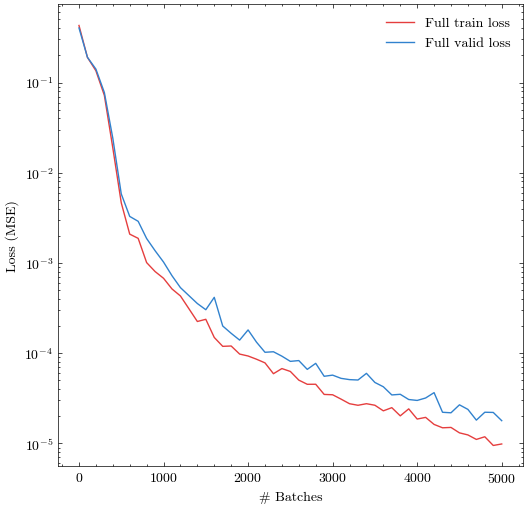

In [7]:
if train:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(net.hist['iters_monitor'], net.hist['train_loss'], color=c_vals[0], label='Full train loss')
    ax.plot(net.hist['iters_monitor'], net.hist['valid_loss'], color=c_vals[1], label='Full valid loss')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    ax.set_yscale('log')
    ax.legend()
    ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_xlabel('# Batches')
    # plt.savefig(f"./results/loss_{hyp_dict['ruleset']}_{task_params['fixate_off']}.png")
    
print('Done!')

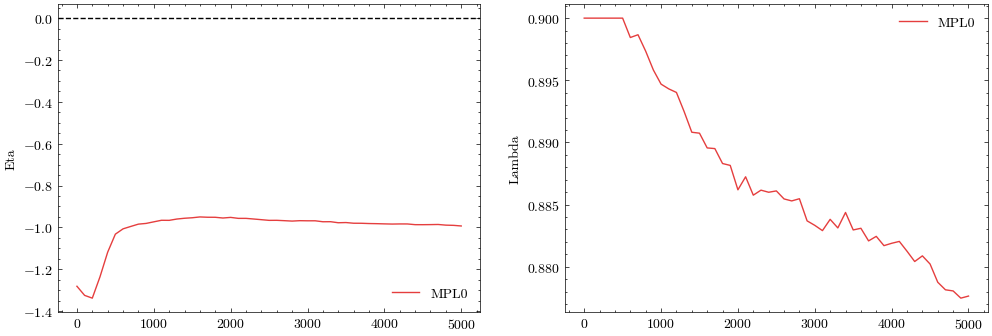

In [8]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

Using network at 100.0%


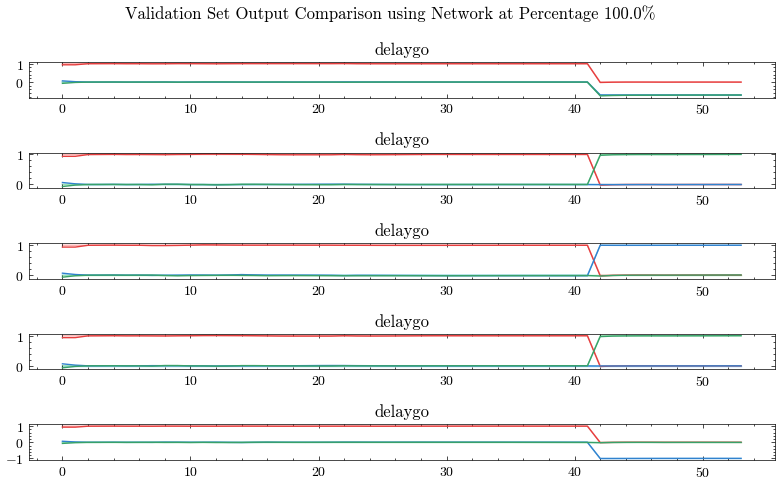

In [9]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    ind = len(marker_lst)-1 
    # ind = 0
    network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    print(f"Using network at {network_at_percent}%")
    net_out = netout_lst[ind]
    db = db_lst[ind]
    W_output = Woutput_lst[ind]
    W_ = Wall_lst[ind][0]

if net_params['loss_type'] in ('MSE',):
    fig, axs = plt.subplots(5, 1, figsize=(8, 5*1))

    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx], zorder=-1)

    else:
        for batch_idx, ax in enumerate(axs):
            task_label = test_input_np[batch_idx, 0, 6-shift_index:]
            task_label_index = np.where(task_label == 1)[0][0]
            for out_idx in range(test_output_np.shape[-1]):
                ax.plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx])
                ax.plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], zorder=-1)
            ax.set_title(task_params['rules'][task_label_index])

    fig.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    fig.tight_layout()
    # fig.savefig(f"./results/lowD_{lag}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}.png")


In [10]:
# here db is selected based on learning stage selection 
def modulation_extraction(db):
    """
    """
    Ms = np.concatenate((
        db['M0'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    Ms_orig = np.concatenate((
        db['M0'].detach().cpu().numpy(),
    ), axis=-1)

    hs = np.concatenate((
        db['hidden0'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    return Ms, Ms_orig, hs
    
if net_params["net_type"] in ("dmpn", ):
    if mpn_depth == 1:
        Ms, Ms_orig, hs = modulation_extraction(db)
    else:
        modulations, hiddens = [], []
        for i in range(mpn_depth):
            modulations.append(db[f'M{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1))
            hiddens.append(db[f'hidden{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),)

        Ms = modulations[0]
        hs = hiddens[0]
        
elif net_params["net_type"] in ("vanilla", "gru"):
    hs = db['hidden'].detach().cpu().numpy()

pca_type = 'full' # full, cell_types
pca_target_lst = ['hs', 'Ms'] # hs, 'Ms' 
if net_params["net_type"] in ("vanilla", "gru"):
    pca_target_lst = ['hs'] # if not dmpn, no M information effectively

# using recorded information
recordkyle_all, recordkyle_nameall = [], []
for test_subtrial in test_trials:
    metaepoch = test_subtrial.epochs
    periodname = list(metaepoch.keys())
    recordkyle, recordkyle_name = [], []
    for keyiter in range(len(periodname)):
        try:
            recordkyle_name.append(periodname[keyiter])
            if test_mode_for_all == "random":
                recordkyle.append(metaepoch[periodname[keyiter]][1])
            elif test_mode_for_all == "random_batch":
                recordkyle.append(list(metaepoch[periodname[keyiter]][1]))
        except Exception as e:
            print(e)
    
    if test_mode_for_all in ("random",):
        fillrecordkyle = []
        for timestamp in recordkyle:
            fillrecordkyle.append([timestamp for _ in range(hs.shape[0])])
        recordkyle = fillrecordkyle

    recordkyle.insert(0, [0 for _ in range(len(recordkyle[1]))])
    recordkyle = np.array(recordkyle).T.tolist()
    recordkyle_all.extend(recordkyle)
    recordkyle_nameall.append(recordkyle_name)

In [11]:
# Sep 30th
# This part of code should be adaptive for multitask, which may have different breaks and periods for each task
unique_lists = set(tuple(lst) for lst in recordkyle_all)
# here select task specific information
# which maximally should have length of number of tasks
unique_recordkyle_all = [list(lst) for lst in unique_lists]
if not task_random_fix:
    assert len(unique_recordkyle_all) >= len(rules_dict[hyp_dict['ruleset']])
else:
    print("Test DataSet Random Seed Is Fixed")

all_session_breakdown = []
for task_specific_time in unique_recordkyle_all:
    session_breakdown = []
    for sindex in range(0,len(task_specific_time)-1):
        # all sessions should be the same for each task
        # but different across tasks
        # though the time of when response period starts might be similar across
        session_breakdown.append([task_specific_time[sindex], task_specific_time[sindex+1]]) 
    session_breakdown.append([task_specific_time[0], task_specific_time[-1]])
    all_session_breakdown.append(session_breakdown)

# break down time
all_breaks = []
for session_breakdown in all_session_breakdown:
    breaks = [cut[1] for cut in session_breakdown[:-1]]
    print(f"Task {all_session_breakdown.index(session_breakdown)}; breaks: {breaks}")
    all_breaks.append(breaks)

# for delay-task
assert len(all_breaks)
response_start = all_breaks[0][-2]

Test DataSet Random Seed Is Fixed
Task 0; breaks: [7, 22, 42, 54]


In [12]:
# sanity check from equation 2-7
def plot_trajectory_by_index(label_index):
    """
    """
    figsize1, figsize2 = 2, 6

    figexh1, axsexh1 = plt.subplots(3,3,figsize=(figsize2*3,figsize1*3))  
    figexh2, axsexh2 = plt.subplots(4,3,figsize=(figsize2*3,figsize1*4))  
    figdiff, axsdiff = plt.subplots(1,1,figsize=(figsize2,figsize1))

    task_middle_dict = {}
    task_labels_across_batch = []

    for batch_iter in range(test_input.shape[0]):
        writeon = 0
        labels_for_batch = labels[batch_iter][0]
        
        if labels_for_batch in label_index: # >=0: for all label; ==0, say, for specific label on the ring (regardless on which task is using)
            xx = test_input[batch_iter, :, :].cpu().numpy()[0,6-shift_index:]
            which_task = np.where(xx)[0][0] # extract here, will repeat later at different time slices
            
            if labels_for_batch not in task_middle_dict.keys():
                task_middle_dict[which_task] = []
                writeon = 1
                
            x_batch_taskinfo = test_input[batch_iter, :, :][:,6-shift_index:].cpu().numpy()[0,:]
            task_specific = np.where(x_batch_taskinfo == 1)[0]
            assert len(task_specific) == 1
            task_specific = task_specific[0]
            
            task_labels_across_batch.append(task_specific) # load task information (which task) across batches
        
            res_eq26, res_eq8, res_eq11 = [], [], []
            res_meta = []

            saver_shape1 = (3,3)
            saver1 = np.empty((saver_shape1[0], saver_shape1[1]), dtype=object)
            saver_shape2 = (4,3)
            saver2 = np.empty((saver_shape2[0], saver_shape2[1]), dtype=object)
        
            for i in range(saver_shape1[0]):
                for j in range(saver_shape1[1]):
                    saver1[i, j] = np.array([])
        
            for i in range(saver_shape2[0]):
                for j in range(saver_shape2[1]):
                    saver2[i, j] = np.array([])
        
            for time_iter in range(test_input.shape[1]):
                x = test_input[batch_iter, time_iter, :].cpu().numpy().reshape(-1,1)
                
                input_length = len(x)
        
                x_fixon, x_fixoff, x_stimulus, x_task = [np.zeros((input_length, 1)) for _ in range(4)]
                # one-hot encoded vector for fixation
                x_fixon[0,0] = x[0,0] 
                # one-hot encoded vector for fixation off (set to dummy if not presented)
                x_fixoff[1,0] = x[1,0] if task_params['fixate_off'] else 0
                # one-hot encoded vector for stimulus
                x_stimulus[2-shift_index:6-shift_index,0] = x[2-shift_index:6-shift_index,0]
                # one-hot encoded vector for task
                # task (dynamically setting for all element after the 6th elements)
                tasks_info = x[6-shift_index:,0]
                x_task[6-shift_index:,0] = tasks_info

                which_task = np.where(tasks_info)[0][0]
                
                Mt = Ms_orig[batch_iter, time_iter, :, :]
                
                middle =  W_ + W_ * Mt

                if time_iter >= response_start + 1 and len(label_index) == 1:
                    if writeon:
                        task_middle_dict[which_task].append(middle)
                
                y_fix = W_output[0,:].reshape(1,-1)
                Y_resp1 = W_output[1,:].reshape(1,-1)
                Y_resp2 = W_output[2,:].reshape(1,-1)
        
                if task_params['fixate_off']:
                    allX1 = [x_fixon+x_task, x_fixoff+x_task, x_stimulus+x_fixon+x_task]
                else:
                    allX1 = [x_fixon+x_task, x_task, x_stimulus+x_fixon+x_task]
                allX1name = ["x_fixon+x_task", "x_fixoff+x_task", "x_stimulus+x_fixon+x_task"]
                allX2 = [x_fixon, x_fixoff, x_stimulus, x_task]
                allX2name = ["x_fixon", "x_fixoff", "x_stimulus", "x_task"]
                allY = [y_fix, Y_resp1, Y_resp2]
                allYname = ["y_fix", "Y_resp1", "Y_resp2"]
        
                for yiter in range(len(allY)):
                    for xiter in range(len(allX1)):
                        # res1 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX1[xiter])
                        res1 = allY[yiter] @ middle @ allX1[xiter]
                        saver1[xiter, yiter] = np.append(saver1[xiter, yiter], res1[0,0])
        
                for yiter in range(len(allY)):
                    for xiter in range(len(allX2)):
                        # res2 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX2[xiter])
                        res2 = allY[yiter] @ middle @ allX2[xiter]
                        saver2[xiter, yiter] = np.append(saver2[xiter, yiter], res2[0,0])
        
            for i in range(saver_shape1[0]):
                for j in range(saver_shape1[1]):
                    axsexh1[i,j].plot(saver1[i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
        
            for i in range(saver_shape2[0]):
                for j in range(saver_shape2[1]):            
                    axsexh2[i,j].plot(saver2[i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
    
            # extract fixon-task information explicitly
            fixon_resp1 = saver2[0,1]
            task_resp1 = saver2[3,1]
            axsdiff.plot(fixon_resp1 + task_resp1, color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
    
    for i in range(saver_shape1[0]):
        for j in range(saver_shape1[1]):
            axsexh1[i,j].set_title(f"{allX1name[i]} & {allYname[j]}")
    
    for i in range(saver_shape2[0]):
        for j in range(saver_shape2[1]):
            axsexh2[i,j].set_title(f"{allX2name[i]} & {allYname[j]}")
    
    for ax in np.concatenate((axsexh1.flatten(), axsexh2.flatten())):
        for breaks in all_breaks:
            for bb in breaks:
                ax.axvline(bb, linestyle="--", c=c_vals[all_breaks.index(breaks)])

    label_index_name = "all" if len(label_index) == 8 else label_index
    
    figexh1.suptitle(f"Exhaustive Search 1 {color_by}")
    figexh1.tight_layout()
    figexh1.savefig(f"./results/es1_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")
    
    figexh2.suptitle(f"Exhaustive Search 2 {color_by}")
    figexh2.tight_layout()
    figexh2.savefig(f"./results/es2_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")
    
    figdiff.suptitle("Fixon-Task")
    figdiff.tight_layout()
    figdiff.savefig(f"./results/diff_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")

    return task_middle_dict if len(label_index) == 1 else {}, task_labels_across_batch # only do it for single task learnig for clarity


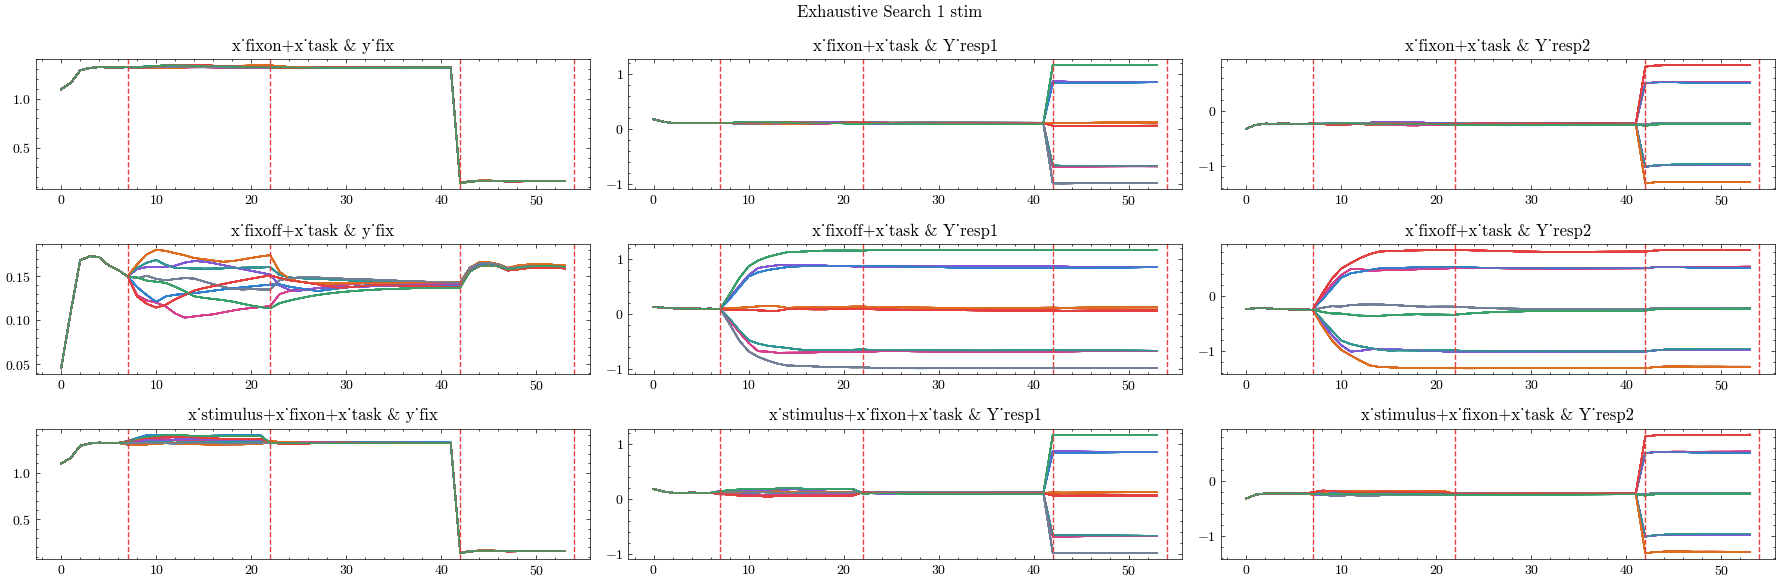

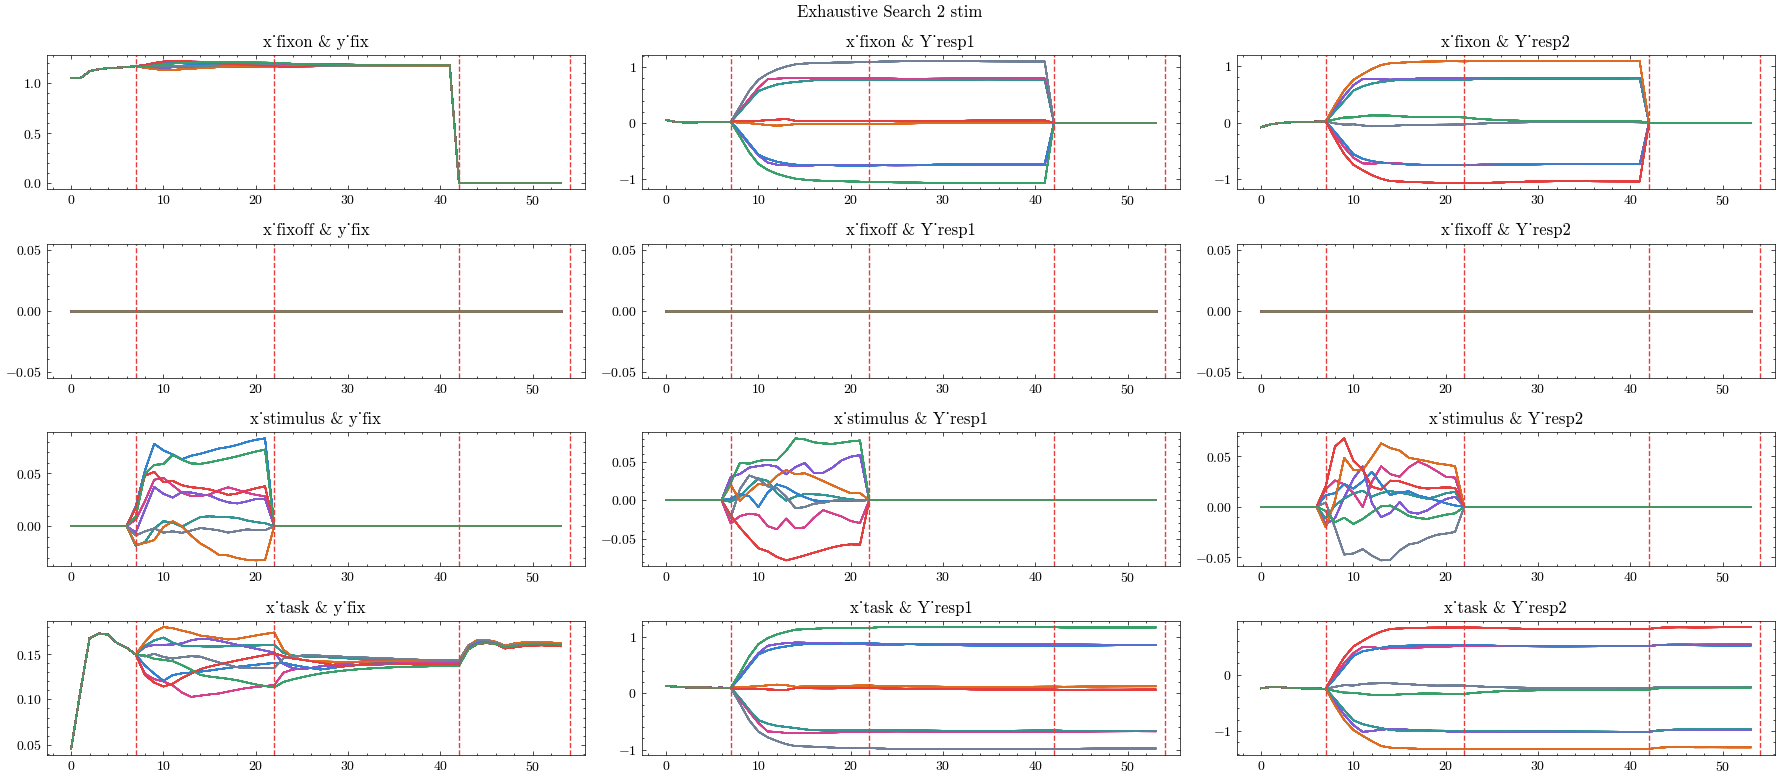

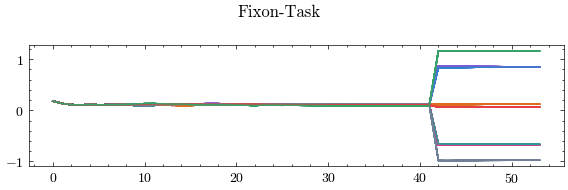

In [13]:
task_middle_dict, task_labels_across_batch = plot_trajectory_by_index(np.unique(labels))
# task_middle_dict = plot_trajectory_by_index([3])

In [14]:
if len(task_middle_dict) > 0:
    tkeys = list(task_middle_dict.keys())
    print(f"Task Info: {tkeys}")
    
    figtime, axstime = plt.subplots(1, 2, figsize=(4*len(tkeys), 4))
    
    for i in range(len(tkeys)):
        middles = task_middle_dict[tkeys[i]]
        middle_task_part = [middle[:,6-shift_index:] for middle in middles]
        
        task_sum = np.concatenate(
            [np.sum(middle_task_time, axis=0, keepdims=True) for middle_task_time in middle_task_part],
            axis=0
        )
        
        for ti in range(task_sum.shape[1]):
            axstime[i].plot(task_sum[:,ti], c=c_vals[ti], label=ti)
            
        axstime[i].set_title(f"Task {tkeys[i]}, Network at {network_at_percent}%")
        axstime[i].legend()

In [15]:
np.sum(test_input.detach().cpu().numpy(), axis=(0,1))

array([ 8400.      ,     0.      ,     0.      ,   114.852875,
         -16.066093, 10800.      ], dtype=float32)

batch_iter: 0


/gscratch/deepthought/zihan/miniconda3/envs/playground/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


batch_iter: 20
batch_iter: 40
batch_iter: 60
batch_iter: 80
batch_iter: 100
batch_iter: 120
batch_iter: 140
batch_iter: 160
batch_iter: 180


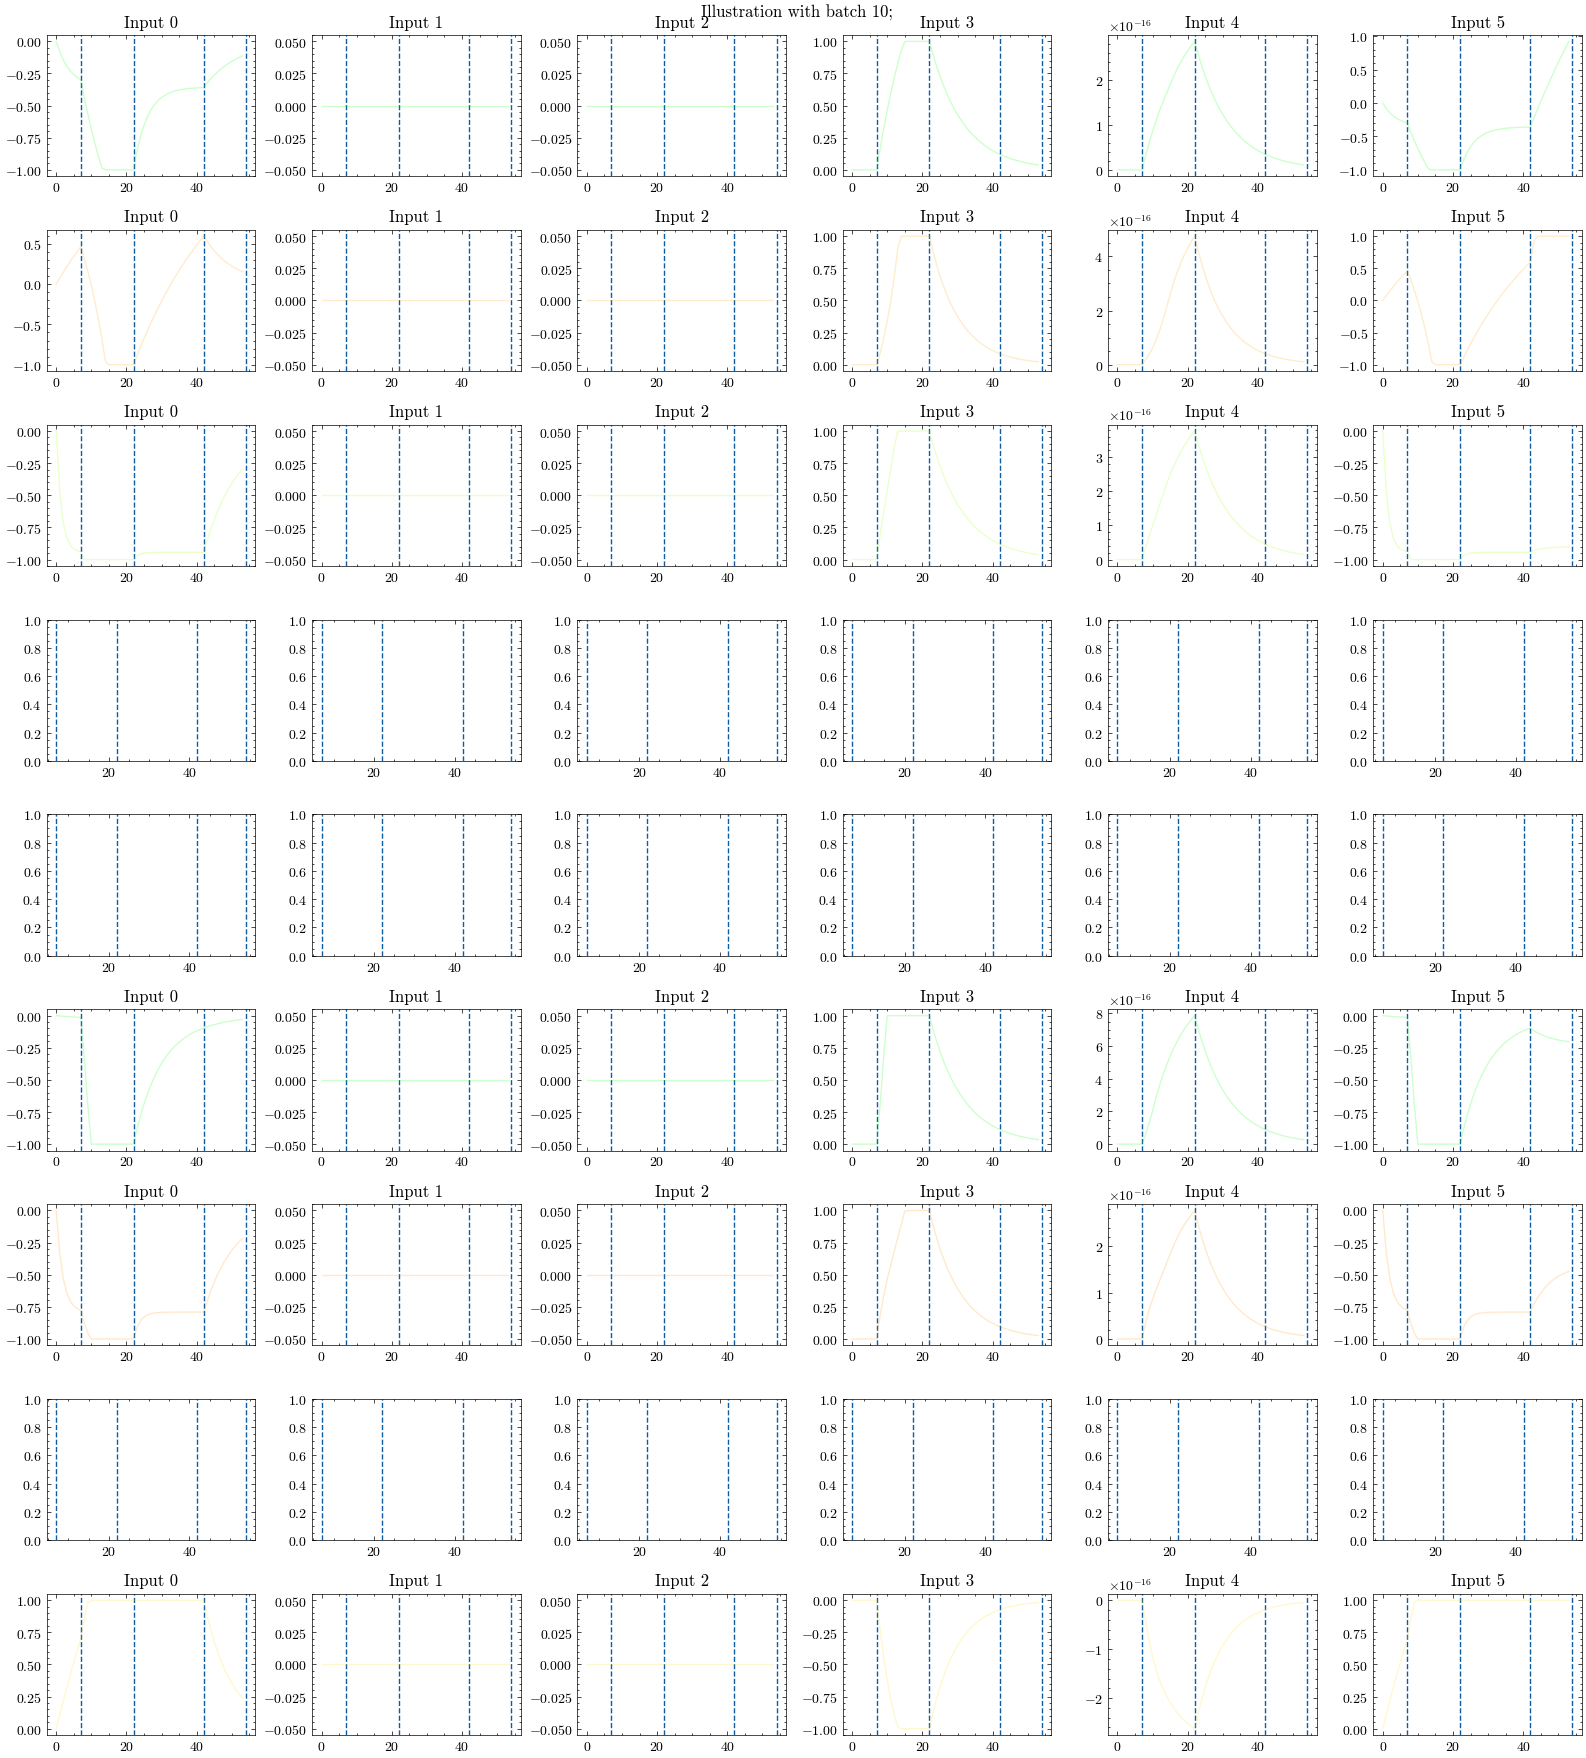

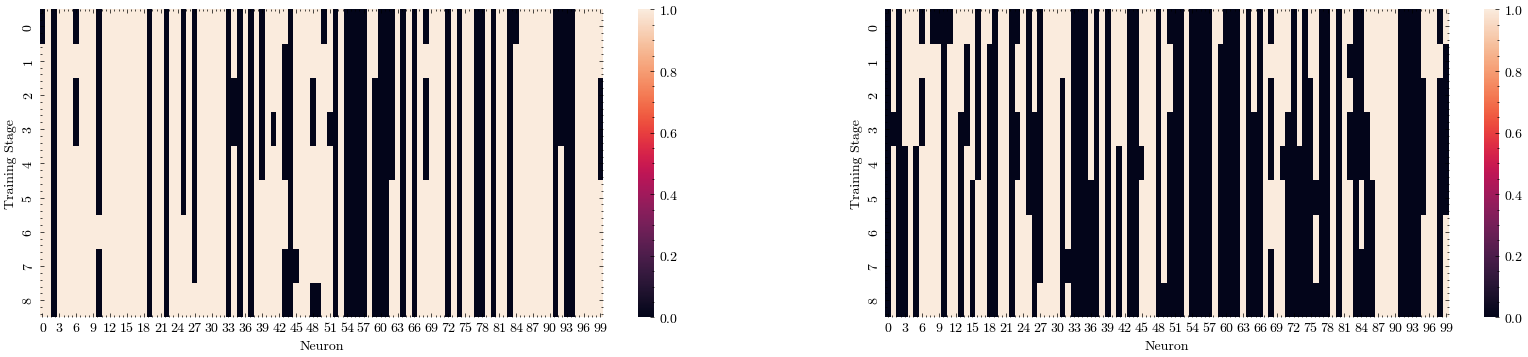

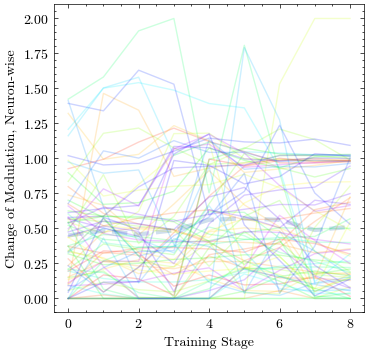

In [109]:
stages_num = len(Wall_lst) # how many recorded neurons in total
break_info = all_breaks[0]

input_nums = Ms_orig.shape[-1]
batch_nums = Ms_orig.shape[0]
neuron_nums = Ms_orig.shape[2]
colors = helper.generate_rainbow_colors(Ms_orig.shape[2])

stimulus_start, stimulus_end, delay_end = break_info[0], break_info[1], break_info[2]

batch_select = 10

overall_corr_change, over_stimulus_info_reserved = [], []

for batch_iter in range(batch_nums):
    if batch_iter % 20 == 0:
        print(f"batch_iter: {batch_iter}")
        
    task_selection = task_labels_across_batch[batch_iter]
    
    stimulus_change_neuron_overtime = []
    stimulus_change_cts_neuron_overtime = []
    stimulus_information_reserved_overtime = []

    if batch_iter == batch_select:
        fig, axs = plt.subplots(stages_num,6,figsize=(8*2,2*stages_num))
        for ax in axs.flatten():
            for breaktime in break_info:
                ax.axvline(breaktime, linestyle="--")

    neuron_respond_stimulus_change, neuron_respond_delay_change = [], []
    for stage_iter in range(stages_num):
        W_ = Wall_lst[stage_iter][0]
        _, Ms_orig, _ = modulation_extraction(db_lst[stage_iter]) # batch * seq_len * hidden_neuron * input_neuron
        middle = W_[np.newaxis, np.newaxis, :, :] * (Ms_orig + 1)

        useful_info = Ms_orig
    
        # how modulation signal is changed during the stimulus period (last timestep minus first timestep)
        stimulus_change_neuron = np.abs(useful_info[batch_iter, stimulus_end-1, :, :] - useful_info[batch_iter, stimulus_start, :, :]) # discrete case (end-before)
        stimulus_change_neuron_cts = np.abs(useful_info[batch_iter, stimulus_start:stimulus_end, :, :] - useful_info[batch_iter, stimulus_start, :, :]) # continuous case (whole trace)
        delay_change_neuron = np.abs(useful_info[batch_iter, delay_end-1, :, :] - useful_info[batch_iter, stimulus_end, :, :])

        # which neuron has significant change of modulation signal
        neuron_to_stimulus = (np.abs(stimulus_change_neuron[:, 0]) > 1e-2).astype(int) # N*1 array
        neuron_respond_stimulus_change.append(neuron_to_stimulus)
        neuron_to_delay = (np.abs(delay_change_neuron[:, 0]) > 1e-2).astype(int) # N*1 array
        neuron_respond_delay_change.append(neuron_to_delay)

        unmatched_neuron = sum(1 for l1, l2 in zip(neuron_to_stimulus, neuron_to_delay) if l2 == 1 and l1 != 1)
        
        # to match up dimension only
        assert task_params['fixate_off'] is False
        # fixon and task (even in multiple, but matched one) will have modulation change oppositely
        assert np.sum(np.abs(stimulus_change_neuron[:,0] - stimulus_change_neuron[:,5+task_selection])) < 1e-5 
        
        stimulus_change_neuron_overtime.append(stimulus_change_neuron)
        stimulus_change_cts_neuron_overtime.append(stimulus_change_neuron_cts)
        
        info_reserved = np.abs(useful_info[batch_iter,break_info[2]-1,:,5+task_selection] - useful_info[batch_iter,break_info[0],:,5+task_selection])
        stimulus_information_reserved_overtime.append(np.mean(info_reserved))

        plot_neuron = random.sample(range(0, neuron_nums), 1)
        
        if batch_iter == batch_select:
            for neuron, color in enumerate(colors[:useful_info.shape[2]]):
                if neuron_to_stimulus[neuron] and neuron in plot_neuron:
                    for j in range(6):
                        axs[stage_iter,j].plot(useful_info[batch_iter, :, neuron, j], alpha=0.2, c=color)
                        axs[stage_iter,j].set_title(f"Input {j}")

    neuron_respond_stimulus_change = np.array(neuron_respond_stimulus_change)
    not_all_zero_neuron_stimulus = np.where(np.any(neuron_respond_stimulus_change != 0, axis=0))[0]
    neuron_respond_delay_change = np.array(neuron_respond_delay_change)
    not_all_zero_neuron_delay = np.where(np.any(neuron_respond_delay_change != 0, axis=0))[0]

    if batch_iter == batch_select:
        ffs, ggs = plt.subplots(1,2,figsize=(10*2,4))
        sns.heatmap(neuron_respond_stimulus_change, ax=ggs[0])
        sns.heatmap(neuron_respond_delay_change, ax=ggs[1])
        for gg in ggs:
            gg.set_xlabel("Neuron")
            gg.set_ylabel("Training Stage")
        
    stimulus_change_neuron_overtime = np.array(stimulus_change_neuron_overtime)
    stimulus_change_cts_neuron_overtime = np.array(stimulus_change_cts_neuron_overtime)
    # print(stimulus_change_neuron_overtime.shape)
    # print(stimulus_change_cts_neuron_overtime.shape)
    
    over_stimulus_info_reserved.append(stimulus_information_reserved_overtime)
    
    if batch_iter == batch_select:
        fig.suptitle(f"Illustration with batch {batch_select}")
        fig.tight_layout()
    
        fig, ax = plt.subplots(figsize=(4,4))
        for neuron in range(stimulus_change_neuron_overtime.shape[1]):
            if neuron in not_all_zero_neuron_stimulus:
                ax.plot(stimulus_change_neuron_overtime[:,neuron,0], alpha=0.2, c=colors[neuron])
        ax.plot(np.mean(stimulus_change_neuron_overtime[:,not_all_zero_neuron_stimulus,0], axis=1), alpha=0.2, linestyle="--",linewidth=3)
        ax.set_xlabel("Training Stage")
        ax.set_ylabel("Change of Modulation, Neuron-wise")


    stage_corr_change = []
    for rec in range(stages_num):
        modulation_change_corr = np.zeros(shape=(input_nums, input_nums))
        for ind1 in range(input_nums):
            for ind2 in range(input_nums):
                input1 = stimulus_change_neuron_overtime[rec,:,ind1].flatten()
                input2 = stimulus_change_neuron_overtime[rec,:,ind2].flatten()
                
                sim, _ = pearsonr(input1, input2)
                
                # responsive_neurons = neuron_respond_stimulus_change[rec]
                # responsive_neurons_index = np.where(responsive_neurons == 1)[0]
                # input1 = stimulus_change_cts_neuron_overtime[rec, :, :, ind1]
                # input2 = stimulus_change_cts_neuron_overtime[rec, :, :, ind2]
                # input1 = input1[:, responsive_neurons_index]
                # input2 = input2[:, responsive_neurons_index]
                
                # corr_matrix = np.corrcoef(input1, input2, rowvar=False)
                # num_neurons = input1.shape[1]
                # simlst2 = corr_matrix[:num_neurons, num_neurons:].diagonal()
                # sim = np.mean(simlst2)                

                modulation_change_corr[ind1, ind2] = sim

        # how fixon interact with stimulus information
        # notice that since the validation set has randomized fix seed
        # some stimulus input may have all zero in specific run
        mean_corr = np.nanmean([modulation_change_corr[0, stimulus_cc] for stimulus_cc in range(1,5)])
        
        stage_corr_change.append(mean_corr)

    overall_corr_change.append(stage_corr_change)

Text(0, 0.5, 'Modulation information of stimulus preserved after delay')

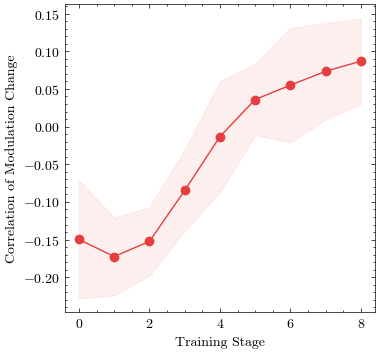

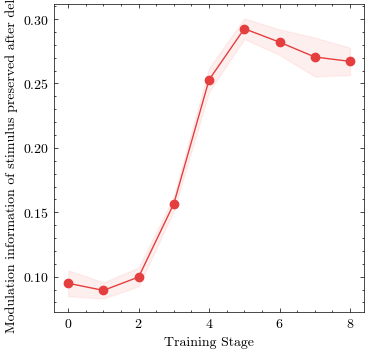

In [110]:
stage_range = [i for i in range(stages_num)]

overall_corr_change = np.array(overall_corr_change)
figcorr, axcorr = plt.subplots(figsize=(4,4))
mean_corr, std_corr = np.mean(overall_corr_change, axis=0), np.std(overall_corr_change, axis=0)
axcorr.plot(stage_range, mean_corr, "-o", color=c_vals[0])
axcorr.fill_between(stage_range, mean_corr-std_corr, mean_corr+std_corr, color=c_vals_l[0], alpha=0.2)
axcorr.set_xlabel("Training Stage")
axcorr.set_ylabel("Correlation of Modulation Change")

over_stimulus_info_reserved = np.array(over_stimulus_info_reserved)
figres, axres = plt.subplots(figsize=(4,4))
mean_res, std_res = np.mean(over_stimulus_info_reserved, axis=0), np.std(over_stimulus_info_reserved, axis=0)
axres.plot(stage_range, mean_res, "-o", color=c_vals[0])
axres.fill_between(stage_range, mean_res-std_res, mean_res+std_res, color=c_vals_l[0], alpha=0.2)
axres.set_xlabel("Training Stage")
axres.set_ylabel("Modulation information of stimulus preserved after delay")

session_part: [0, 7]; pca_target: hs
as_shape: (200, 7, 100)
PR: 1.14
PCA component PRs - PC1: 41.3, PC2: 30.6, PC3: 36.4
session_part: [0, 7]; pca_target: Ms
as_shape: (200, 7, 600)
PR: 1.14
PCA component PRs - PC1: 119.7, PC2: 88.4, PC3: 81.8
session_part: [7, 22]; pca_target: hs
as_shape: (200, 15, 100)
PR: 2.27
PCA component PRs - PC1: 43.2, PC2: 50.7, PC3: 37.5
session_part: [7, 22]; pca_target: Ms
as_shape: (200, 15, 600)
PR: 3.21
PCA component PRs - PC1: 180.4, PC2: 172.1, PC3: 104.1
session_part: [22, 42]; pca_target: hs
as_shape: (200, 20, 100)
PR: 2.60
PCA component PRs - PC1: 23.0, PC2: 23.1, PC3: 17.3
session_part: [22, 42]; pca_target: Ms
as_shape: (200, 20, 600)
PR: 3.60
PCA component PRs - PC1: 126.2, PC2: 124.2, PC3: 149.5
session_part: [42, 54]; pca_target: hs
as_shape: (200, 12, 100)
PR: 2.82
PCA component PRs - PC1: 8.5, PC2: 6.9, PC3: 6.8
session_part: [42, 54]; pca_target: Ms
as_shape: (200, 12, 600)
PR: 3.82
PCA component PRs - PC1: 58.2, PC2: 51.1, PC3: 129.8
ses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PR: 4.19
PCA component PRs - PC1: 44.5, PC2: 61.3, PC3: 62.6
session_part: [0, 54]; pca_target: Ms
as_shape: (200, 54, 600)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PR: 4.93
PCA component PRs - PC1: 158.0, PC2: 155.3, PC3: 219.0


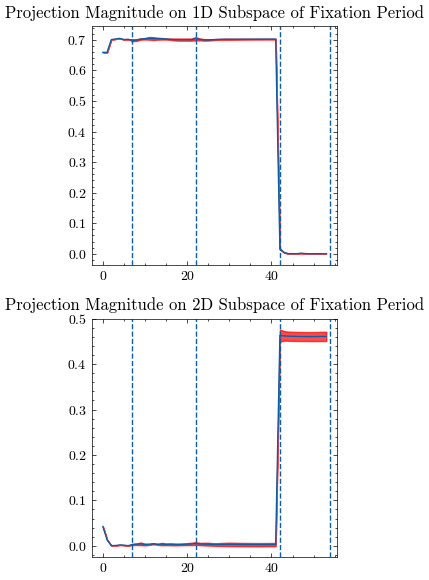

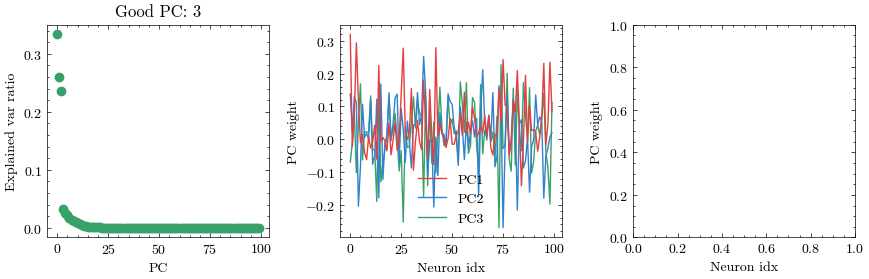

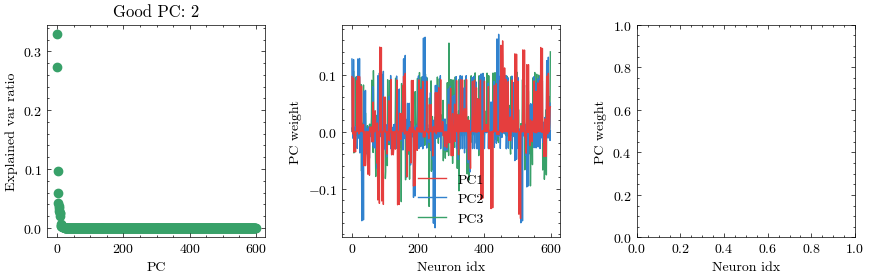

In [19]:
for session_iter in range(0,len(session_breakdown)):
    session_part = session_breakdown[session_iter]

    for pca_target in pca_target_lst:
        print(f"session_part: {session_part}; pca_target: {pca_target}")

        if net.hidden_cell_types is not None:
            cell_types = net.hidden_cell_types.detach().cpu().numpy()[0] # Remove batch idx
        cell_type_names = ('Inh.', 'Exc.')
        pca_sort_type = 'ratios' # How to sort cell type PCA; vars, ratios

        if pca_target in ('hs',):
            n_activity = hs.shape[-1]
            # Truncate into session specifically
            hs_cut = hs[:,session_part[0]:session_part[1],:]
            as_shape = hs_cut.shape 
            as_flat = hs_cut.reshape((-1, n_activity,))
        elif pca_target in ('Ms',):
            n_activity = Ms.shape[-1]
            # Truncate into session specifically
            Ms_cut = Ms[:,session_part[0]:session_part[1],:]
            # as_shape = (Ms.shape[0], Ms.shape[1], n_activity) 
            as_shape = Ms_cut.shape
            as_flat = Ms_cut.reshape((-1, n_activity))

        print(f"as_shape: {as_shape}")
        as_shape_saver = as_shape

        total_vars = np.var(as_flat, axis=0) # Var per activity dimension
        activity_zero = np.zeros((1, n_activity,))

        if pca_type in ('full',):
            activity_pca = PCA()

            activity_pca.fit(as_flat)
            
            # Corrects signs of components so that their mean/average is positive
            activity_pca.components_ = np.sign(np.sum(activity_pca.components_, axis=-1))[:, np.newaxis] * activity_pca.components_
            
            as_pca = activity_pca.transform(as_flat)
            # as_pca = as_pca.reshape(as_shape) # Separates back into batches and sequences
            as_pca = as_pca.reshape(as_shape_saver[0],as_shape_saver[1],-1)

            zeros_pca = activity_pca.transform(activity_zero)
            if pca_target in ('hs',): # Some transformations only make sense for certain activities
                W_output_pca = activity_pca.transform(W_output)

            # ZIHAN: only do for all period trial (last)
            #
            # Should we use PCA result or the original result?
            #
            if session_iter == len(session_breakdown)-1 and pca_target in ('hs', ):
                output_num = W_output.shape[0]
                assert output_num == 3 # low_dim
                figtest, axstest = plt.subplots(2,1,figsize=(3*1,3*2))
                # ? Original or PCA
                fixation_pca = W_output[0,:].reshape(1,-1)
                # fixation_pca = fixation_pca / np.linalg.norm(fixation_pca, axis=1, keepdims=True)
                stimulus_pca = W_output[1:,:]
                # stimulus_pca = stimulus_pca / np.linalg.norm(stimulus_pca, axis=1, keepdims=True)
                batch_record_fixate, batch_record_stimulus = [], []
                
                for batchiter in range(hs_cut.shape[0]):
                    # ? Original or PCA
                    batch_activity_pca = hs_cut[batchiter,:,:]
                    
                    batch_record1, batch_record2 = [], []
                    for timestamp in range(batch_activity_pca.shape[0]):
                        batch_time_activity_pca = batch_activity_pca[timestamp,:].reshape(1,-1)
                        #
                        # batch_time_activity_pca = batch_time_activity_pca / np.linalg.norm(batch_time_activity_pca, axis=1, keepdims=True)

                        projection_magnitude_fix = helper.magnitude_of_projection(batch_time_activity_pca, fixation_pca)
                        batch_record1.append(projection_magnitude_fix)
                        projection_magnitude_stimulus = helper.magnitude_of_projection(batch_time_activity_pca, stimulus_pca)
                        batch_record2.append(projection_magnitude_stimulus)
                        # print(f"projection_magnitude_fix: {projection_magnitude_fix}; projection_magnitude_stimulus: {projection_magnitude_stimulus}")
                        # time.sleep(10000)
                    batch_record_fixate.append(batch_record1)
                    batch_record_stimulus.append(batch_record2)

                batch_record_fixate, batch_record_stimulus = np.array(batch_record_fixate), np.array(batch_record_stimulus)
                mean_fix, std_fix = np.mean(batch_record_fixate, axis=0), np.std(batch_record_fixate, axis=0)
                mean_stimulus, std_stimulus = np.mean(batch_record_stimulus, axis=0), np.std(batch_record_stimulus, axis=0)
                xxx = [i for i in range(mean_fix.shape[0])]
                axstest[0].plot(xxx, mean_fix)
                axstest[0].fill_between(xxx, mean_fix-std_fix, mean_fix+std_fix, alpha=0.7, color="red")
                axstest[0].set_title("Projection Magnitude on 1D Subspace of Fixation Period")
                axstest[1].plot(xxx, mean_stimulus)
                axstest[1].fill_between(xxx, mean_stimulus-std_stimulus, mean_stimulus+std_stimulus, alpha=0.7, color="red")
                axstest[1].set_title("Projection Magnitude on 2D Subspace of Fixation Period")
                for ax in axstest:
                    for spp in session_breakdown[:-1]:
                        ax.axvline(spp[1], linestyle="--")
                figtest.tight_layout()
                figtest.show()
                # figtest.savefig(f"./results/zz_test_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_test.png")
            
            print('PR: {:.2f}'.format(
                helper.participation_ratio_vector(activity_pca.explained_variance_ratio_)
            ))
            print('PCA component PRs - PC1: {:.1f}, PC2: {:.1f}, PC3: {:.1f}'.format(
                    helper.participation_ratio_vector(np.abs(activity_pca.components_[0, :])),
                    helper.participation_ratio_vector(np.abs(activity_pca.components_[1, :])),
                    helper.participation_ratio_vector(np.abs(activity_pca.components_[2, :])),
                ))

        elif pca_type in ('cell_types',):
            raise NotImplementedError('Need to correct this for Ms activity')
            cell_type_vals = np.unique(cell_types) # Gets unique cell type idxs

            n_cell_types = cell_type_vals.shape[0]
            pcas = [PCA() for _ in range(n_cell_types)]

            cell_types_pca = [] # This needs to be diferent from cell_types because may do cell types in a different order
            hs_pca = []
            explained_vars = []
            explained_var_ratios = []

            zeros_pca = []
            W_output_pca = []
            # Fit each PCA individually
            for cell_type_idx, (cell_type_val, cell_type_name) in enumerate(zip(
                cell_type_vals, cell_type_names
            )):
                print('Cell type: {}'.format(cell_type_name))
                cell_type_filter = (cell_types == cell_type_val)
                n_cells_type = np.sum(cell_type_filter.astype(np.int32))

                print(' Ratio of population: {:.2f}, variance: {:.2f}'.format(
                    n_cells_type / n_cells,
                    np.sum(total_vars[cell_type_filter]) / np.sum(total_vars)
                ))

                pcas[cell_type_idx].fit(hs_flat[:, cell_type_filter])
                # Corrects signs of components so that their mean/average is positive
                pcas[cell_type_idx].components_ = np.sign(np.sum(pcas[cell_type_idx].components_, axis=-1))[:, np.newaxis] * pcas[cell_type_idx].components_

                hs_pca_type = pcas[cell_type_idx].transform(hs_flat[:, cell_type_filter])

                print(' PR: {:.2f}'.format(
                    helper.participation_ratio_vector(pcas[cell_type_idx].explained_variance_ratio_)
                ))
                print(' PCA component PRs - PC1: {:.1f}, PC2: {:.1f}, PC3: {:.1f}'.format(
                    helper.participation_ratio_vector(np.abs(pcas[cell_type_idx].components_[0, :])),
                    helper.participation_ratio_vector(np.abs(pcas[cell_type_idx].components_[1, :])),
                    helepr.participation_ratio_vector(np.abs(pcas[cell_type_idx].components_[2, :])),
                ))

                cell_types_pca.append([cell_type_val for _ in range(n_cells_type)])
                hs_pca.append(hs_pca_type)
                explained_vars.append(pcas[cell_type_idx].explained_variance_)
                explained_var_ratios.append(pcas[cell_type_idx].explained_variance_ratio_)

                zeros_pca.append(pcas[cell_type_idx].transform(hidden_zero[:, cell_type_filter]))
                W_output_pca.append(pcas[cell_type_idx].transform(W_output[:, cell_type_filter]))

            explained_vars = np.concatenate(explained_vars, axis=-1)
            explained_var_ratios = np.concatenate(explained_var_ratios, axis=-1)
            # Now sort based on explained variances/explained variance ratio
            if pca_sort_type in ('vars',):
                pca_type_sort = np.argsort(explained_vars)[::-1] # largest to smallest
            elif pca_sort_type in ('ratios',):
                pca_type_sort = np.argsort(explained_var_ratios)[::-1] # largest to smallest

            cell_types_pca =  np.concatenate(cell_types_pca, axis=-1)[pca_type_sort]
            hs_pca = np.concatenate(hs_pca, axis=-1)[:, pca_type_sort]
            explained_vars = explained_vars[pca_type_sort]
            explained_var_ratios = explained_var_ratios[pca_type_sort]
            zeros_pca = np.concatenate(zeros_pca, axis=-1)[:, pca_type_sort]
            W_output_pca = np.concatenate(W_output_pca, axis=-1)[:, pca_type_sort]
            print('Overall:')
            print(' PR: {:.2f}'.format(
                participation_ratio_vector(explained_var_ratios)
            ))
            hs_pca = hs_pca.reshape(hs.shape)

        if session_iter == len(session_breakdown)-1:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*3, 3))
            n_pcs_plot = 3

            if pca_type in ('full',):
                ax1.scatter(np.arange(n_activity), activity_pca.explained_variance_ratio_, color=c_vals[2])
                cutoff = np.sum(activity_pca.explained_variance_ratio_ > 0.1) # PC with > 0.1 

                for pc_idx in range(n_pcs_plot):
                    ax2.plot(activity_pca.components_[pc_idx, :], color=c_vals[pc_idx], label='PC{}'.format(pc_idx+1),
                            zorder=5-pc_idx)

            ax1.set_xlabel('PC')
            ax1.set_ylabel('Explained var ratio')
            ax1.set_title(f"Good PC: {cutoff}")

            for ax in (ax2, ax3):
                ax.legend()
                ax.set_xlabel('Neuron idx')
                ax.set_ylabel('PC weight')

            fig.show()
            fig.tight_layout()
            # fig.savefig(f"./results/PC_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}.png")

/tmp/ipykernel_10760/2010025921.py:111: RuntimeWarning: invalid value encountered in arccos
  angle_deg = np.degrees(np.arccos(dot_product))


[[0, 7], [7, 22], [22, 42], [42, 54], [0, 54]]


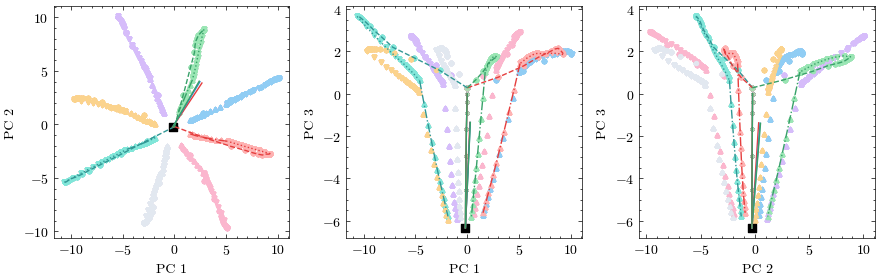

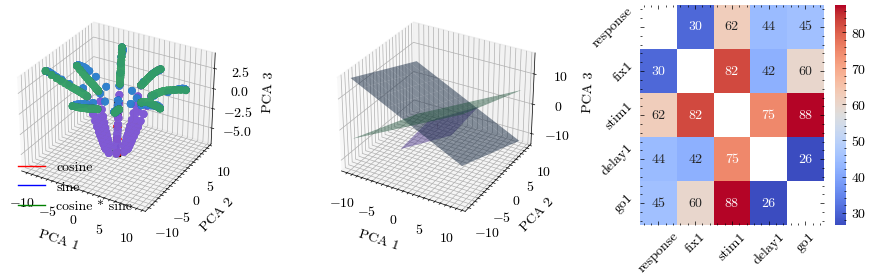

In [20]:
for session_iter in range(len(session_breakdown)-1,len(session_breakdown)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*3, 3))

    # single_rule: color by labels
    # all_rules: color by rule
    # if multiple testrules are detected, automatically plot based on the rule type
    plot_mode = 'single_rule' if len(task_params["rules"]) == 1 else 'all_rules'

    if plot_mode == 'single_rule':
        rule_idx = 0 # Only used for individual labels
        rule = task_params['rules'][rule_idx]
        rule_batch_idxs = np.arange(n_batch_all)[test_rule_idxs == rule_idx]
    elif plot_mode == 'all_rules':
        rule_batch_idxs = np.arange(n_batch_all)

    if pca_target in ('hs'):
        pc1_idx, pc2_idx, pc3_idx = 0,1,2
    elif pca_target in ('Ms'):
        pc1_idx, pc2_idx, pc3_idx = 0,1,2

    # batch_plot = (0, 1, 2,)
    if task_params['dataset_name'] in ('DelayMatchSample-v0',):
        batch_plot = [False, False, False, False] # 4 distinct paths
    else:
        batch_plot = (0, 1, 2,)
    
    # ZIHAN
    # additional analysis
    if session_iter == len(session_breakdown)-1 and pca_target in ('hs', 'Ms'):
        all_normal_vectors = []
        # minus the zero activity pca
        pc_indices_consider = [pc1_idx, pc2_idx, pc3_idx]

        cosine_pc = np.hstack([W_output_pca[1, idx] - zeros_pca[:, idx] for idx in pc_indices_consider])
        # cosine_pc = np.vstack((W_output_pca[1,pc1_idx]-zeros_pca[:,pc1_idx], W_output_pca[1,pc2_idx]-zeros_pca[:,pc2_idx], W_output_pca[1,pc3_idx]-zeros_pca[:,pc3_idx])).reshape(-1)
        cosine_pc = cosine_pc / np.linalg.norm(cosine_pc)

        sine_pc = np.hstack([W_output_pca[2, idx] - zeros_pca[:, idx] for idx in pc_indices_consider])
        # sine_pc = np.vstack((W_output_pca[2,pc1_idx]-zeros_pca[:,pc1_idx], W_output_pca[2,pc2_idx]-zeros_pca[:,pc2_idx], W_output_pca[2,pc3_idx]-zeros_pca[:,pc3_idx])).reshape(-1)
        sine_pc = sine_pc / np.linalg.norm(sine_pc)

        normal_cosine_sine = np.cross(cosine_pc, sine_pc)
        # normalization
        normal_cosine_sine = normal_cosine_sine / np.linalg.norm(normal_cosine_sine)
        all_normal_vectors.append(normal_cosine_sine)

        figscatter = plt.figure(figsize=(3*3, 3))
        ax1_3d = figscatter.add_subplot(131, projection='3d')
        ax2_3d = figscatter.add_subplot(132, projection='3d')
        ax3_3d = figscatter.add_subplot(133)

        init_point_3d = np.stack((zeros_pca[:, pc1_idx], zeros_pca[:, pc2_idx], zeros_pca[:, pc3_idx]), axis=1)
        ax1_3d.scatter(init_point_3d[0,0], init_point_3d[0,1], init_point_3d[0,2], marker="s", color="black")

        ax1_3d.plot([init_point_3d[0,0], init_point_3d[0,0] + cosine_pc[0]],
                    [init_point_3d[0,1], init_point_3d[0,1] + cosine_pc[1]],
                    [init_point_3d[0,2], init_point_3d[0,2] + cosine_pc[2]],
                    color='red', label="cosine")

        ax1_3d.plot([init_point_3d[0,0], init_point_3d[0,0] + sine_pc[0]],
                    [init_point_3d[0,1], init_point_3d[0,1] + sine_pc[1]],
                    [init_point_3d[0,2], init_point_3d[0,2] + sine_pc[2]],
                    color='blue', label="sine")

        ax1_3d.plot([init_point_3d[0,0], init_point_3d[0,0] + normal_cosine_sine[0]],
                    [init_point_3d[0,1], init_point_3d[0,1] + normal_cosine_sine[1]],
                    [init_point_3d[0,2], init_point_3d[0,2] + normal_cosine_sine[2]],
                    color='green', label="cosine * sine")
        
        ax1_3d.legend()

        for ii in range(len(session_breakdown[:-1])):
            subsession = session_breakdown[ii]
            clustered_points = as_pca[:, subsession[0]:subsession[1], :]
            
            # Extract the principal components for the scatter plot
            pc1_points = clustered_points[:, :, pc1_idx].flatten()
            pc2_points = clustered_points[:, :, pc2_idx].flatten()
            pc3_points = clustered_points[:, :, pc3_idx].flatten()
            
            ax1_3d.scatter(pc1_points, pc2_points, pc3_points, c=c_vals[ii], alpha=0.15)

            points_3d = np.vstack((pc1_points, pc2_points, pc3_points)).T
            # points_3d_centered = points_3d - np.mean(points_3d, axis=0)
            scaler = StandardScaler()
            points_3d_standardized = scaler.fit_transform(points_3d)
            pca = PCA(n_components=3)
            pca.fit(points_3d_standardized)
            normal_vector = pca.components_[-1]
            normalized_normal_vector = normal_vector / np.linalg.norm(normal_vector)
            all_normal_vectors.append(normalized_normal_vector)

            point = np.mean(points_3d, axis=0)
            d = -point.dot(normal_vector)
            xx, yy = np.meshgrid(np.linspace(np.min(points_3d[:, 0]), np.max(points_3d[:, 0]), 10), 
                                np.linspace(np.min(points_3d[:, 1]), np.max(points_3d[:, 1]), 10))
            zz = (-normal_vector[0] * xx - normal_vector[1] * yy - d) * 1. / normal_vector[2]
            
            ax2_3d.plot_surface(xx, yy, zz, alpha=0.5, color=c_vals_d[ii])

        for thisax in [ax1_3d, ax2_3d]:
            thisax.set_xlabel(f"PCA {pc1_idx+1}")
            thisax.set_ylabel(f"PCA {pc2_idx+1}")
            thisax.set_zlabel(f"PCA {pc3_idx+1}")

        nnn = len(all_normal_vectors)
        normal_align = np.zeros((nnn, nnn))
        for n1 in range(nnn):
            for n2 in range(nnn):
                dot_product = np.dot(all_normal_vectors[n1], all_normal_vectors[n2])
                angle_deg = np.degrees(np.arccos(dot_product))
                # consider both alignment and anti-alignment
                angle_deg = min(angle_deg, 180.0-angle_deg)
                normal_align[n1,n2] = angle_deg

        np.fill_diagonal(normal_align, np.nan)
        # mark_labels = ["response"] + [f"period {i+1}" for i in range(nnn-1)]
        mark_labels = ["response"] + recordkyle_nameall[0]

        sns.heatmap(normal_align, cbar=True, annot=True, ax=ax3_3d, cmap='coolwarm', xticklabels=mark_labels, yticklabels=mark_labels)
        ax3_3d.set_xticklabels(ax3_3d.get_xticklabels(), rotation=45)
        ax3_3d.set_yticklabels(ax3_3d.get_yticklabels(), rotation=45)

        figscatter.tight_layout()
        # figscatter.savefig(f"./results/zz_test_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_scatter.png")

        # what if not based on PC -> Aug 3nd
        
        # middle of each session
        breaks_1afterstart = [int((cut[0]+cut[1])/2) for cut in session_breakdown[:-1]]

        # plot more frames 
        considerall = 0
        if considerall:
            for cut in session_breakdown[:-1]:
                breaks_1afterstart.append(cut[0])
                breaks_1afterstart.append(cut[1]-1)
        breaks_1afterstart = list(np.sort(breaks_1afterstart))
        print(session_breakdown)

        # if pca_target in ('hs',): # in random
        #     figall, axsall = plt.subplots(3,2,figsize=(2*4,3*4))
        #     figavg, axsavg = plt.subplots(3,2,figsize=(2*4,3*4))

        #     assert mpn_depth == 1 # for now
        #     W_ = W_all_[0]

        #     # plot two trials
        #     figW, axsW = plt.subplots(len(breaks_1afterstart)+1,4,figsize=(12*4,4*(len(breaks_1afterstart)+1)))
        #     select_batch = [29,49,69,89]
        #     for pp in select_batch:
        #         sns.heatmap(W_.T, cbar=True, cmap="coolwarm", ax=axsW[0,select_batch.index(pp)])
        #         axsW[0,select_batch.index(pp)].set_title("W")
        #         # take average across batches
        #         # Ms_samplebatch = np.mean(Ms_orig, axis=0) 
        #         Ms_samplebatch = Ms_orig[pp,:,:,:]
        #         print(Ms_samplebatch.shape)

        #         for bb in breaks_1afterstart:
        #             sns.heatmap(Ms_samplebatch[bb,:,:].T, cbar=True, cmap="coolwarm", center=0, \
        #                                 vmin=-1, vmax=1, ax=axsW[breaks_1afterstart.index(bb)+1,select_batch.index(pp)])

        #         for bb in breaks_1afterstart:
        #             axsW[breaks_1afterstart.index(bb)+1,select_batch.index(pp)].set_title(f"M: Time: {bb}")
        #             axsW[breaks_1afterstart.index(bb)+1,select_batch.index(pp)].set_xlabel(f"Neuron")
        #             axsW[breaks_1afterstart.index(bb)+1,select_batch.index(pp)].set_ylabel(f"Input Index")

        #     figW.tight_layout()
        #     figW.savefig(f"./results/zz_test_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_W.png")

        #     results = {
        #         'fix_hs_Woutput_all': [],
        #         'response_hs_Woutput_all': [],
        #         'fix_Ms_Woutput_all': [],
        #         'response_Ms_Woutput_all': [],
        #         'fix_MsWs_Woutput_all': [],
        #         'response_MsWs_Woutput_all': [],
        #     }

        #     pltout, axsout = plt.subplots(figsize=(3,3))
        #     sns.heatmap(W_output, ax=axsout, cmap="coolwarm", center=0, cbar=True, square=True)
        #     pltout.savefig(f"./results/zz_test_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_Woutput.png")

        #     W_output_fixation = W_output[0,:].reshape(-1,1) # (N,1)
        #     W_output_response = W_output[1:3,:].T # (N,2)


        #     for batch_iter in range(hs.shape[0]):
        #         hs_per_batch = hs[batch_iter,:,:]
        #         Ms_per_batch = Ms_orig[batch_iter,:,:,:]

        #         fix_hs_Woutput, response_hs_Woutput = [], []
        #         fix_Ms_Woutput, response_Ms_Woutput = [], []
        #         fix_MsWs_Woutput, response_MsWs_Woutput = [], []
                
        #         for time_cut in range(hs_per_batch.shape[0]):
        #             hs_per_batch_per_time = hs_per_batch[time_cut,:].reshape(-1,1) # (N,1)
        #             Ms_per_batch_per_time = Ms_per_batch[time_cut,:,:] # (N, n_input)

        #             ang_fix_hs_Ws = subspace_angles(hs_per_batch_per_time, W_output_fixation)[0]
        #             fix_hs_Woutput.append(np.degrees(ang_fix_hs_Ws))

        #             ang_response_hs_Ws = subspace_angles(hs_per_batch_per_time, W_output_response)[0]
        #             response_hs_Woutput.append(np.degrees(ang_response_hs_Ws))

        #             try:
        #                 ang_fix_Ms_Ws = subspace_angles(Ms_per_batch_per_time, W_output_fixation)[0]
        #                 fix_Ms_Woutput.append(np.degrees(ang_fix_Ms_Ws))
        #             except:
        #                 fix_Ms_Woutput.append(np.nan)
                    
        #             try:
        #                 ang_response_Ms_Ws = subspace_angles(Ms_per_batch_per_time, W_output_response)[0]
        #                 response_Ms_Woutput.append(np.degrees(ang_response_Ms_Ws))
        #             except:
        #                 response_Ms_Woutput.append(np.nan)

        #             try:
        #                 ang_fix_MsWs_Ws = subspace_angles(Ms_per_batch_per_time * W_ + W_, W_output_fixation)[0]
        #                 fix_MsWs_Woutput.append(np.degrees(ang_fix_MsWs_Ws))
        #             except:
        #                 fix_MsWs_Woutput.append(np.nan)
                    
        #             try:
        #                 ang_response_MsWs_Ws = subspace_angles(Ms_per_batch_per_time * W_ + W_, W_output_response)[0]
        #                 response_MsWs_Woutput.append(np.degrees(ang_response_MsWs_Ws))
        #             except:
        #                 response_MsWs_Woutput.append(np.nan)


        #         results['fix_hs_Woutput_all'].append(fix_hs_Woutput)
        #         results['response_hs_Woutput_all'].append(response_hs_Woutput)
        #         results['fix_Ms_Woutput_all'].append(fix_Ms_Woutput)
        #         results['response_Ms_Woutput_all'].append(response_Ms_Woutput)
        #         results['fix_MsWs_Woutput_all'].append(fix_MsWs_Woutput)
        #         results['response_MsWs_Woutput_all'].append(response_MsWs_Woutput)

        #     for key in results:
        #         results[key] = np.array(results[key])
            
        #     result_key = list(results.keys())
        #     axsall = axsall.flatten()
        #     for batch_iter in range(hs.shape[0]):
        #         for key in result_key:
        #             axsall[result_key.index(key)].plot([x for x in range(results[key].shape[1])], results[key][batch_iter,:], color=c_vals[labels[batch_iter,0]])             
        #             axsall[result_key.index(key)].set_title(key)

        #     for ax in axsall.flatten():
        #         for bb in breaks:
        #             ax.axvline(bb, color='r', linestyle="--")

        #     breaks = [0] + breaks
        #     axsavg = axsavg.flatten()
        #     for key in result_key:
        #         means, stds = [], []
        #         for bb in range(len(breaks)-1):
        #             meanp = np.nanmean(results[key][:,breaks[bb]:breaks[bb+1]])
        #             stdp = np.nanstd(results[key][:,breaks[bb]:breaks[bb+1]])
        #             means.append(meanp)
        #             stds.append(stdp)
        #         means, stds = np.array(means), np.array(stds)
        #         axsavg[result_key.index(key)].plot([x for x in range(len(means))], means, "-o")
        #         axsavg[result_key.index(key)].fill_between([x for x in range(len(means))], means-stds, means+stds, alpha=0.3, color="red")
        #         axsavg[result_key.index(key)].set_title(key)

        #     figall.show()
        #     figavg.show()
        #     figall.savefig(f"./results/zz_test_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_all2all.png")
        #     figavg.savefig(f"./results/zz_test_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_all2allavg.png")

    for ax, pc_idxs in zip((ax1, ax2, ax3),((pc1_idx, pc2_idx), (pc1_idx, pc3_idx), (pc2_idx, pc3_idx))):
        domain_save = []
        for batch_idx_idx, batch_idx in enumerate(rule_batch_idxs):
            if plot_mode == 'single_rule':
                batch_color_idx = labels[batch_idx][0]
            elif plot_mode == 'all_rules':
                batch_color_idx = int(test_rule_idxs[batch_idx])

            # MODIFY BY ZIHAN
            # only plot the categorization at the whole final period
            # where all sections are included in plotting
            if session_iter == len(session_breakdown)-1:
                cutoff_evidence = recordkyle_all
                
                temp = []
                for jj in range(len(cutoff_evidence[batch_idx])-1):
                    xx = as_pca[batch_idx, cutoff_evidence[batch_idx][jj]:cutoff_evidence[batch_idx][jj+1], pc_idxs[0]]
                    yy = as_pca[batch_idx, cutoff_evidence[batch_idx][jj]:cutoff_evidence[batch_idx][jj+1], pc_idxs[1]]
                    temp.append([xx, yy])
                    ax.scatter(xx, yy, color=c_vals_l[batch_color_idx], alpha=0.7, marker=markers_vals[jj], s=8)
                domain_save.append(temp)

                if batch_idx_idx in batch_plot:
                    for jj in range(len(cutoff_evidence[batch_idx])-1):
                        ax.plot(as_pca[batch_idx, cutoff_evidence[batch_idx][jj]:cutoff_evidence[batch_idx][jj+1], pc_idxs[0]], 
                                as_pca[batch_idx, cutoff_evidence[batch_idx][jj]:cutoff_evidence[batch_idx][jj+1], pc_idxs[1]], 
                                color=c_vals[batch_color_idx], 
                                linestyle=l_vals[jj], alpha=1.0, zorder=10
                        )

            else:
                ax.scatter(as_pca[batch_idx, :, pc_idxs[0]], as_pca[batch_idx, :, pc_idxs[1]], color=c_vals_l[batch_color_idx], alpha=0.7, marker="o", s=8)

        if pca_type in ('full',):
            ax.set_xlabel('PC {}'.format(pc_idxs[0]+1))
            ax.set_ylabel('PC {}'.format(pc_idxs[1]+1))
        elif pca_type in ('cell_types',):
            ax.set_xlabel('PC {} (cell type: {})'.format(pc_idxs[0]+1, cell_types_pca[pc_idxs[0]]))
            ax.set_ylabel('PC {} (cell type: {})'.format(pc_idxs[1]+1, cell_types_pca[pc_idxs[1]]))
        # Plot zero point
        ax.scatter(zeros_pca[:, pc_idxs[0]], zeros_pca[:, pc_idxs[1]], color='k',
                marker='s')

        # Plot readouts
        ro_vector_dir_all = []
        init_points = []
        # if pca_target in ('Ms',):
        #     continue
        for out_idx, output_dim_label in enumerate(output_dim_labels):
            if pca_target in ('Ms',):
                RO_SCALE = 5
            elif pca_target in ('hs',):
                RO_SCALE = 1

            ro_vector_dir = np.array((
                W_output_pca[out_idx, pc_idxs[0]] - zeros_pca[:, pc_idxs[0]],
                W_output_pca[out_idx, pc_idxs[1]] - zeros_pca[:, pc_idxs[1]],
            ))

            norm = np.linalg.norm(ro_vector_dir)

            if norm != 0:
                ro_vector_dir = ro_vector_dir / norm
            else:
                ro_vector_dir = ro_vector_dir

            ro_vector_dir = RO_SCALE * ro_vector_dir
            ro_vector_dir_all.append(ro_vector_dir)

            init_point = [zeros_pca[:, pc_idxs[0]], zeros_pca[:, pc_idxs[1]]]

            ax.plot((zeros_pca[:, pc_idxs[0]], zeros_pca[:, pc_idxs[0]] + ro_vector_dir[0]),
                    (zeros_pca[:, pc_idxs[1]], zeros_pca[:, pc_idxs[1]] + ro_vector_dir[1]),
                    color=c_vals[out_idx], label=output_dim_label, zorder=9)

            init_points.append(init_point)
            
    fig.show()
    fig.tight_layout()
    # fig.savefig(f"./results/trajectory_{pca_target}_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_period{session_iter}.png")

In [21]:
print(db.keys())

if len(rules_dict[hyp_dict['ruleset']]) > 1:
    hs_all = []
    if net_params['net_type'] in ('dmpn',):
        layer_idx_lst = [i for i in range(mpn_depth)]
        for layer_idx in layer_idx_lst:
            if layer_idx == 0:
                hs = db['hidden0'].detach().cpu().numpy()
            elif layer_idx == 1:
                hs = db['hidden1'].detach().cpu().numpy()
            hs_all.append(hs)
    elif net_params['net_type'] in ('gru',):
        layer_idx_lst = [0]
        hs_all = [db['hidden'].detach().cpu().numpy()]

    for hsiter in range(len(hs_all)):
        hs = hs_all[hsiter]
        layer_name = layer_idx_lst[hsiter]

        cell_vars_tot = np.var(hs, axis=(0, 1)) # Var over batch and sequence
        n_rules = len(task_params['rules'])
        n_cells = hs.shape[-1]

        # cell_vars_dtypes = [('rule{}'.format(rule_idx), np.float) for rule_idx in range(n_rules)]# Useful for sorting later
        cell_vars_rules = np.zeros((n_rules, n_cells,))
        cell_vars_rules_norm = np.zeros_like(cell_vars_rules)

        for rule_idx, rule in enumerate(task_params['rules']):
            print('Rule {} (idx {})'.format(rule, rule_idx))
            rule_hs = hs[test_rule_idxs == rule_idx, :, :]
            cell_vars_rules[rule_idx] = np.var(rule_hs, axis=(0, 1)) # Var over batch and sequence

        # Now normalize everything
        cell_max_var = np.max(cell_vars_rules, axis=0) # Across rules
        for rule_idx, rule in enumerate(task_params['rules']):
            cell_vars_rules_norm[rule_idx] = np.where(
                cell_max_var > 0., cell_vars_rules[rule_idx] / cell_max_var, 0.
            )

        # Now sort
        if n_rules > 1:
            rule0_vals = cell_vars_rules_norm[0].tolist()
            rule1_vals = cell_vars_rules_norm[1].tolist()

        rule01_vals = np.array(list(zip(rule0_vals, rule1_vals)), dtype=[('rule0', float), ('rule1', float)])
        sort_idxs = np.argsort(rule01_vals, order=['rule0', 'rule1'])[::-1]

        # sort_idxs = np.argsort(cell_vars_rules_norm[0])[::-1]
        cell_vars_rules_sorted_norm = cell_vars_rules_norm[:, sort_idxs]

        fig, ax = plt.subplots(2, 1, figsize=(12, 3*2))

        for rule_idx, rule in enumerate(task_params['rules']):
            ax[0].plot(cell_vars_rules_sorted_norm[rule_idx], color=c_vals[rule_idx],
                    label=task_params['rules'][rule_idx])

        ax[0].legend()

        ax[0].set_xlabel('Cell_idx')
        ax[0].set_ylabel('Norm. task var.')


        ax[1].matshow(cell_vars_rules_sorted_norm, aspect='auto', vmin=0.0, vmax=1.0,)
        ax[1].set_yticks(np.arange(n_rules))
        ax[1].set_yticklabels(task_params['rules'])
        ax[1].set_xlabel('Cell idx')
        fig.show()
        # fig.savefig(f"./results/categorization_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_layer_{layer_name}_{hyp_dict['addon_name']}.png")

dict_keys(['hidden_pre0', 'hidden0', 'M0'])
